In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent))

# import better_exceptions
from scikit_quri.qnn.regressor import QNNRegressor
import numpy as np
from numpy.random import default_rng

from quri_parts.core.operator import Operator, pauli_label
from quri_parts.core.estimator.gradient import (
    create_numerical_gradient_estimator)
from quri_parts.qulacs.estimator import (
    create_qulacs_vector_concurrent_parametric_estimator,
    create_qulacs_vector_concurrent_estimator,
)
from quri_parts.algo.optimizer import Adam
from scikit_quri.circuit.pre_defined import create_qcl_ansatz

def generate_noisy_sine(x_min, x_max, num_x):
    rng = default_rng(0)
    x_train = [[rng.uniform(x_min, x_max)] for _ in range(num_x)]
    y_train = [np.sin(np.pi * x[0]) for x in x_train]
    mag_noise = 0.01
    y_train += mag_noise * rng.random(num_x)
    # return np.array(x_train), np.array(y_train)
    return np.array(x_train).flatten(), np.array(y_train)

x_train,y_train = generate_noisy_sine(-1.,1.,80)
x_test,y_test = generate_noisy_sine(-1.,1.,80)

In [2]:
from quri_parts.circuit.utils.circuit_drawer import draw_circuit
import matplotlib.pyplot as plt
n_qubits = 5
depth = 6
n_outputs = 1
parametric_circuit = create_qcl_ansatz(n_qubits,depth,0.5,0)

op = Operator()
for i in range(n_outputs):
    op.add_term(pauli_label(f"Z {i}"),1.0)
draw_circuit(parametric_circuit.circuit)

estimator = create_qulacs_vector_concurrent_estimator()
gradient_estimator = create_numerical_gradient_estimator(create_qulacs_vector_concurrent_parametric_estimator(),delta=1e-10)
adam = Adam()

   ___     ___     ___     ___     ___     ___     ___     ___     ___     ___  
  |PRY|   |PRZ|   |Mat|   |PRX|   |PRZ|   |PRX|   |Mat|   |PRX|   |PRZ|   |PRX| 
--|0  |---|1  |---|10 |---|11 |---|12 |---|13 |---|26 |---|27 |---|28 |---|29 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    ___     ___     ___    |   |    ___     ___     ___  
  |PRY|   |PRZ|   |   |   |PRX|   |PRZ|   |PRX|   |   |   |PRX|   |PRZ|   |PRX| 
--|2  |---|3  |---|   |---|14 |---|15 |---|16 |---|   |---|30 |---|31 |---|32 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    ___     ___     ___    |   |    ___     ___     ___  
  |PRY|   |PRZ|   |   |   |PRX|   |PRZ|   |PRX|   |   |   |PRX|   |PRZ|   |PRX| 
--|4  |---|5  |---|   |---|17 |---|18 |---|19 |---|   |---|33 |---|34 |---|35 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    _

In [3]:
init_params = 2*np.pi*np.random.rand(parametric_circuit.n_learning_params)

In [4]:
qnn = QNNRegressor(n_qubits,parametric_circuit,estimator,gradient_estimator,adam,op)

qnn.fit(x_train,y_train,maxiter=30)

init_params=array([1.96101161, 2.79445738, 2.50110619, 4.45010224, 2.82653715,
       3.85923788, 0.47720971, 1.03747838, 2.36909666, 3.01158399,
       2.39271439, 2.48189297, 4.94783127, 3.03714085, 0.65549319,
       4.69956346, 2.6703006 , 1.1927865 , 2.78081119, 5.57082724,
       2.41888863, 0.02687372, 3.34045724, 4.83567061, 6.06776981,
       0.70021351, 2.60353088, 1.19915596, 3.03117354, 4.66209654,
       1.02312951, 1.00638087, 1.81826376, 5.06165667, 5.41353346,
       2.90122254, 4.99397248, 2.01229429, 5.13403321, 1.43193068,
       3.80761646, 2.0732364 , 4.53678199, 5.18446387, 4.39553391,
       6.22294295, 1.91646142, 5.88031601, 3.91919148, 3.00777219,
       2.25787994, 4.35480088, 0.18379948, 3.04205916, 1.29945626,
       0.8702071 , 5.56402434, 3.79646514, 1.8285908 , 1.26978787,
       0.79359341, 2.29435404, 0.17241617, 1.15766909, 0.07158086,
       1.82049906, 0.93901441, 5.52474138, 2.53867631, 3.94746852,
       4.69937071, 2.37683963, 2.65630042, 3.19970

cost=0.015555796083211716


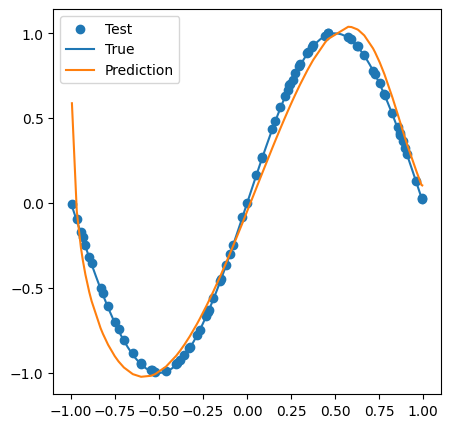

In [ ]:
y_pred = qnn.predict(x_test)
y_test = y_test.reshape(-1,1)
plt.figure(figsize=(5,5))

plt.scatter(
    np.sort(x_test.flatten()),
    y_test[np.argsort(x_test.flatten())],label="Test")

x_true = np.linspace(-1,1,100)
y_true = np.sin(np.pi * x_true)
plt.plot(x_true,y_true,label="True")
plt.plot(
    np.sort(x_test.flatten()),
    y_pred[np.argsort(x_test.flatten())],
    label="Prediction")
plt.legend()

from sklearn.metrics import mean_squared_error
loss = mean_squared_error(y_test,y_pred)
print(f"{loss=}")
plt.show()